# Phần 2 — CNN (Convolutional Neural Network) trên Digits (8×8)

**Bối cảnh thực tế:** Nhận dạng chữ số viết tay (0–9).  
**Ứng dụng thực tế:** Nhập liệu tự động, đọc mã bưu chính, chấm thi trắc nghiệm, OCR đơn giản, v.v.

> Ghi chú: Bộ **Digits** là ảnh xám 8×8 tích hợp sẵn trong `scikit-learn` (không cần tải dữ liệu). Chúng ta dùng **PyTorch** để xây CNN đơn giản.

Dùng thiết bị: cpu
Epoch 01: loss=2.2795 | test_acc=0.4139
Epoch 02: loss=2.1474 | test_acc=0.6306
Epoch 03: loss=1.7540 | test_acc=0.6556
Epoch 04: loss=1.1539 | test_acc=0.8250
Epoch 05: loss=0.7239 | test_acc=0.8472
Epoch 06: loss=0.5025 | test_acc=0.8861
Epoch 07: loss=0.3849 | test_acc=0.8889
Epoch 08: loss=0.3176 | test_acc=0.8972


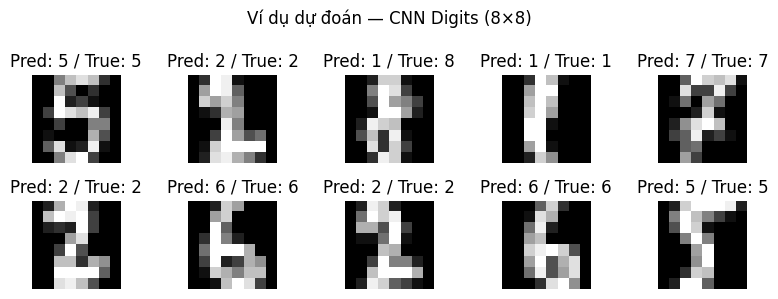

In [2]:
# Kiểm tra PyTorch trước khi chạy
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import TensorDataset, DataLoader
    from sklearn.datasets import load_digits
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    import matplotlib.pyplot as plt
    import numpy as np

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Dùng thiết bị:", device)

    # 2.1) Tải dữ liệu Digits (ảnh 8x8), chuẩn hoá về [0,1]
    digits = load_digits()
    X = digits.images  # shape: (n_samples, 8, 8)
    y = digits.target  # 0..9

    X = X / 16.0  # dữ liệu gốc là 0..16, chia 16 để về [0,1]

    # Chuyển sang tensor: cần shape (N, C, H, W) => (N, 1, 8, 8)
    X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
    y = torch.tensor(y, dtype=torch.long)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    train_ds = TensorDataset(X_train, y_train)
    test_ds  = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    test_loader  = DataLoader(test_ds, batch_size=128, shuffle=False)

    # 2.2) Định nghĩa mô hình CNN nhỏ gọn cho ảnh 8x8
    class SmallCNN(nn.Module):
        def __init__(self):
            super().__init__()
            self.net = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=3, padding=1),  # (1,8,8) -> (16,8,8)
                nn.ReLU(),
                nn.MaxPool2d(2),                             # (16,8,8) -> (16,4,4)
                nn.Conv2d(16, 32, kernel_size=3, padding=1), # (32,4,4)
                nn.ReLU(),
                nn.MaxPool2d(2),                             # (32,4,4) -> (32,2,2)
            )
            self.fc = nn.Sequential(
                nn.Flatten(),
                nn.Linear(32*2*2, 64),
                nn.ReLU(),
                nn.Linear(64, 10)
            )
        def forward(self, x):
            x = self.net(x)
            x = self.fc(x)
            return x

    model = SmallCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # 2.3) Huấn luyện nhanh (vài epoch cho nhanh)
    EPOCHS = 8
    for epoch in range(1, EPOCHS+1):
        model.train()
        total_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)
        avg_loss = total_loss / len(train_loader.dataset)

        # Đánh giá nhanh trên test
        model.eval()
        all_preds, all_targets = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb).argmax(dim=1)
                all_preds.append(preds.cpu().numpy())
                all_targets.append(yb.cpu().numpy())
        all_preds = np.concatenate(all_preds)
        all_targets = np.concatenate(all_targets)
        acc = accuracy_score(all_targets, all_preds)
        print(f"Epoch {epoch:02d}: loss={avg_loss:.4f} | test_acc={acc:.4f}")

    # 2.4) Hiển thị một vài dự đoán
    model.eval()
    fig, axes = plt.subplots(2, 5, figsize=(8,3))
    axes = axes.ravel()
    shown = 0
    with torch.no_grad():
        for i in range(10):
            img = X_test[i:i+1].to(device)
            pred = model(img).argmax(dim=1).item()
            axes[i].imshow(X_test[i,0].cpu(), cmap="gray")
            axes[i].set_title(f"Pred: {pred} / True: {y_test[i].item()}")
            axes[i].axis("off")
    plt.suptitle("Ví dụ dự đoán — CNN Digits (8×8)")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("Không thể chạy phần CNN do thiếu PyTorch hoặc lỗi khác. Chi tiết:", e)
    print("Vui lòng cài PyTorch (CPU) bằng lệnh:")
    print("  pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu")


## 2.5) Ghi chú học thuật (ngắn gọn)
- **Vì sao dùng CNN cho ảnh?** CNN khai thác tính cục bộ (local patterns) thông qua tích chập (convolution), tham số ít hơn MLP, học đặc trưng không gian tốt hơn cho dữ liệu ảnh.
- **Digits 8×8** là bộ nhỏ, chạy rất nhanh; với dữ liệu ảnh lớn hơn (MNIST 28×28, CIFAR-10 32×32, ...), kiến trúc CNN có thể mở rộng theo cùng nguyên lý.
- **Ứng dụng thực tế:** nhận dạng chữ số trên hoá đơn, phiếu trả lời trắc nghiệm, địa chỉ bưu chính, số đồng hồ điện/nước, v.v.